In [7]:
import pandas as pd
import logging
import tqdm
import time
from pathlib import Path

import torch
from transformers import BartForSequenceClassification, BartTokenizer, BartConfig
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# internal libraries
from resources import target_to_label

# set a seed value
torch.manual_seed(2022)

log = logging.getLogger(__name__)
log.setLevel(logging.WARNING)

**Params**

In [8]:
results_dir = Path("results")

"""Check true target in X highest predicted targets"""
top_X_targets = 5

model_path = "valhalla/distilbart-mnli-12-9"

dataset_path = "data/afd_targets_odd_12_15_16.csv"

In [9]:
targets = list(target_to_label.keys())
targets.append("0")

labels = list(target_to_label.values())

results_dir.mkdir(exist_ok=True)    # create output dir
now = time.time()

label_to_target = {v: k for k, v in target_to_label.items()}

# create output file
with open(results_dir / Path(f"zs-nli-{now}.csv"), "w") as f:
    f.write(
        "text,target1,target2,exec_time,"
        + ",".join([k for k in target_to_label.keys()])
        + "\n"
    )

In [10]:
config = BartConfig.from_pretrained(model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForSequenceClassification.from_pretrained(model_path)
model.eval()

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((10

In [11]:
def predict(premise, hypothesis):
    """
    Function to run a prediction
    :param premise:
    :param hypothesis: Hypothesis based on the premise
    :return: Probability that the hypothesis is true based on the premise
    """
    # run through model pre-trained on MNLI
    # :warning: text is truncate
    input_ids = tokenizer.encode(
        premise, hypothesis, truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        logits = model(input_ids)[0]

    # we throw away "neutral" (dim 1) and take the probability of
    # "entailment" (2) as the probability of the label being true
    entail_contradiction_logits = logits[:, [0, 2]]

    probs = entail_contradiction_logits.softmax(dim=1)
    true_prob = probs[:, 1].item() * 100
    logging.info(f"Probability that '{hypothesis}' is true: {true_prob:0.2f}%")

    return true_prob

In [12]:
# df true
df_true = pd.read_csv(dataset_path)

y_true, y_pred = [], []

pbar = tqdm.tqdm(150)

for index, row in df_true.iterrows():  # text

    results = {k: "" for k in target_to_label.keys()}

    start_time = time.time()

    text = row["text"]
    for label in labels:
        # Build hypothesis
        hypothesis = "The context is " + label

        # Run prediction
        true_prob = predict(text, hypothesis)

        target = label_to_target[label]
        results[target] = true_prob

    exec_time = time.time() - start_time
    logging.info(f"Total prediction time : {exec_time:0.2f}s")    

    # add result to output file
    with open(results_dir / Path(f"zs-nli-{now}.csv"), "a") as f:
        new_line = (
            f'"{text}",{exec_time},{row["target1"]},{row["target2"]},'
            + ",".join([f"{v:.2f}" for v in results.values()])
            + "\n"
        )
        f.write(new_line)

    top_X_targets_list = []
    target_highest_score = max(results, key=results.get)
    # find X targets with highest score
    for _ in range(top_X_targets):
        target_max_temp = max(results, key=results.get)

        top_X_targets_list.append(target_max_temp)
        results.pop(target_max_temp)

    y_true.append(row["target1"])
    # if truth in X highest targets, append truth
    if row["target1"] in top_X_targets_list:
        y_pred.append(row["target1"])
    # else append target with the highest score
    else:
        y_pred.append(target_highest_score)

    del results
    pbar.update(1)

65it [22:56, 21.18s/it]


/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/guillaume/hackathon-odd/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

              precision    recall  f1-score   support

        12.1       0.00      0.00      0.00         0
        12.2       0.03      1.00      0.06         1
        12.3       0.00      0.00      0.00         2
        12.4       0.96      0.85      0.90        27
        12.5       0.82      0.82      0.82        11
        12.6       0.00      0.00      0.00         0
        12.7       0.50      1.00      0.67         1
        12.8       0.00      0.00      0.00         0
        12.a       1.00      0.50      0.67         2
        12.b       0.00      0.00      0.00         0
        12.c       0.00      0.00      0.00         0
        15.1       0.74      0.93      0.82        15
        15.2       1.00      0.50      0.67         6
        15.3       1.00      0.25      0.40         4
        15.4       0.00      0.00      0.00         0
        15.5       0.78      1.00      0.88         7
        15.6       1.00      0.25      0.40         4
        15.7       0.00    

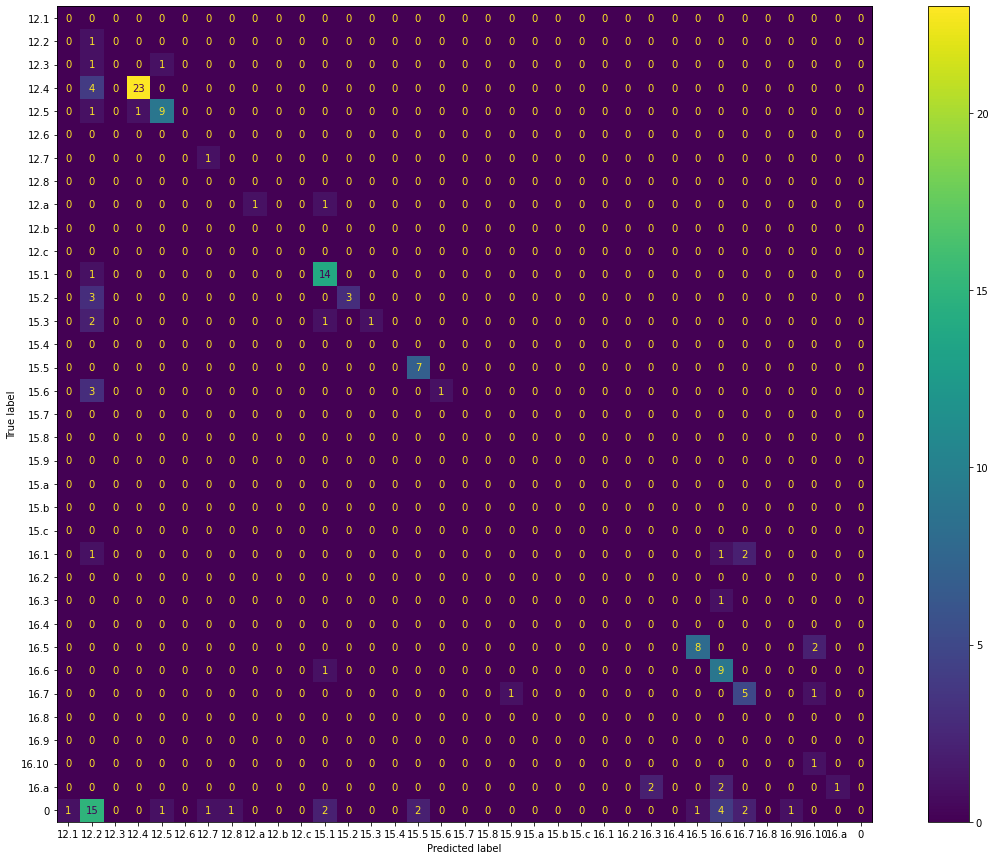

In [13]:
print(classification_report(y_true, y_pred, labels=targets))

fig, ax = plt.subplots(figsize=(20, 15))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=targets, ax=ax)